###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth.

# Coding Assignment: Rocket

The equations of motion for a rocket in purely vertical flight are given by

\begin{align}
\frac{dh}{dt} &= v\\
(m_s+m_p) \frac{dv}{dt}& = -(m_s+m_p)g + \dot{m}_pv_e - \frac{1}{2}\rho v|v|AC_D
\end{align}

$h$ is the altitude of the rocket

$m_s = 50kg$ is the weight of the rocket shell

$g = 9.81 \frac{m}{s^2}$

$\rho = 1.091 \frac{kg}{m^3}$ is the average air density (assumed constant throughout flight)

$A = \pi r^2$ is the maximum cross sectional area of the rocket, where $r = 0.5 m$

$v_e = 325 \frac{m}{s}$ is the exhaust speed

$C_D = 0.15 $ is the drag coefficient

$m_{po} = 100 kg$ at time $t = 0$ is the initial weight of the rocket propellant

The mass of the remaining propellant is given by:

$$m_p = m_{po} - \int^t_0 \dot{m}_p d\tau$$

where $\dot{m}_p$ is the time-varying burn rate given by the following figure:

Propellant Burn Rate

![burn rate](./burn.rate.png)

Using Euler's method with a timestep of $\Delta t=0.1s$, create a Python script to calculate the altitude and velocity of the rocket from launch until crash down.  






## Assessment:

To check your answers, you can register for [MAE 6286: Practical Numerical Methods with Python](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about).

1. At time $t=3.2s$, what is the mass (in kg) of rocket propellant remaining in the rocket?

2. What is the maximum speed of the rocket in $\frac{m}{s}$?
    At what time does this occur (in seconds)? 
    What is the altitude at this time (in meters)? 
    
3. What is the rocket's maximum altitude during flight (in meters)? At what time (in seconds) does this occur?

4. At what time (in seconds) does the rocket impact the ground? What is the velocity of the rocket (in $\frac{m}{s}$) at time of impact?

## Derivation of the rocket equations

In case you are kind of confused about the rocket equations, here we show how to get to them. 

Newton's second law states that the acceleration of the vehicle times its mass is equal to all the forces acting on it. Therefore,

\begin{equation}
(m_s + m_p)\frac{d\bf{v}}{dt}=\sum {\bf F}.
\end{equation}
In the above formula we have assumed that the propellant inside the rocket and the rocket move at the same velocity (in other words, their relative velocity is negligible). 

Two of the external forces acting on the rocket are,

\begin{align}
{\bf F}_g&= (m_s+m_p)\bf{g} \quad (\rm{Gravity}),\\
{\bf F}_d&= - \frac{1}{2} \rho_a \mathbf{v} |\mathbf{v}| A  C_D \quad (\rm{Drag}).
\end{align}

We also need to consider the force resulting from the ejection of the propellant. During an interval $dt$, the engine of the rocket ejects downwards a mass of propellant given by $\dot m_p dt$. Relative to the rocket, the speed of the ejected burning gas is assumed constant and equal to $v_e$ (the exhaust speed). The momentum variation induced on the exhaust gas by the engine during that interval is therefore, $d{\bf p}_{gas} = \dot m_p {\bf v}_e dt$. Again using Newton's second law we conclude that the force applied by the rocket on the gas is,

\begin{align}
{\bf F}_{rocket\rightarrow gas} = \frac{d{\bf p}_{gas}}{dt} = \dot m_p {\bf v}_e
\end{align}

Using Newton's third law (|action| = |reaction|), the force exerted by the exhaust gas on the rocket is then,

\begin{align}
{\bf F}_{gas\rightarrow rocket} = -{\bf F}_{rocket\rightarrow gas} = -\dot m_p {\bf v}_e
\end{align}

If we collect all the forces acting on the rocket we finally have:

\begin{align}
(m_s + m_p)\frac{d\bf{v}}{dt}=(m_s+m_p){\bf g}- \frac{1}{2} \rho_a \mathbf{v} |v| A  C_D -\dot m_p {\bf v}_e
\end{align}



## Initial value Problem

### Load the modules and libraries that we need for this problem

In [760]:
from math import sin, cos, log, ceil, pi
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

### Set things up to start our numerical solution

In [761]:
# model parameters:
g = 9.81      # gravity in m s^{-2}
M_S = 50     # weight of rocket shell
rho = 1.091  # average air density
r = 0.5      # cross sectional radius of rocket
A = numpy.pi * r**2  # max. cross sectional radius of rocket
V_E = 325   # exhaust speed
C_D = 0.15   # drag coefficient --- or D/L if C_L=1

### set initial conditions ###
H0 = 0
V0 = 0
M_P0 = 100  # initial weight of rocket propellant


### Define a function f() to match the right-hand side of our equations

In [762]:
def f(u, params):
    """Returns the right-hand side of the rocket system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    # extract params
    dt = params[0]
    V_E = params[1]
    g = params[2]
    rho = params[3]
    C_D = params[4]
    m_s = params[5]
    
    h = u[0]
    v = u[1]    
    m_p = u[2]  
    
    if m_p > 0:
        dmp = - 20 # decrease the mass of the propellant
    else:
        dmp = 0
       
            
    m_t = m_p + m_s        
    
    return numpy.array([v,
                      (g*m_t - m_p*V_E - 0.5*rho*v*numpy.abs(v)*A*C_D) / m_t,
                       dmp])

### Euler's method is implemented in a simple function

In [763]:
def euler_step(u, f, params):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    dt = params[0]
    
    return u + dt * f(u, params)

### Construct the grid

In [764]:
T = 60                          # final time
dt = 0.1                           # time increment
N = int(T/dt) + 1                  # number of time-steps
t = numpy.linspace(0, T, N)      # time discretization

# initialize the array containing the solution for each time-step
u = numpy.empty((N, 3))
u[0] = numpy.array([H0, V0, M_P0])# fill 1st element with initial values

params = [dt, V_E, g, rho, C_D, M_S]


# time loop - Euler method
for n in range(0, N-1):  
    u[n+1] = euler_step(u[n], f, params)
    
    

## Plot the trajectory

### get the rocket's position with respect to the time

In [765]:
h = u[:,0];
v = u[:,1];
m = u[:,2] + M_S;

### Time to plot the height of the rocket

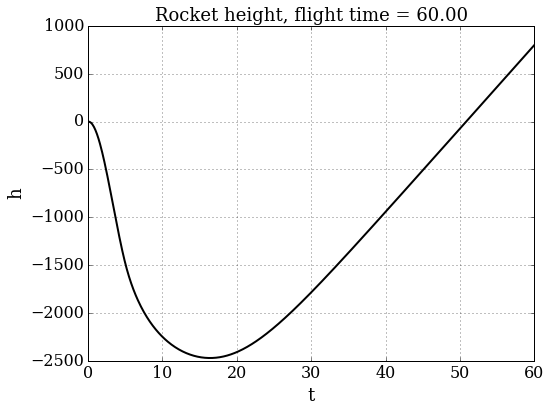

In [766]:
# visualization of the height
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r't', fontsize=18)
pyplot.ylabel(r'h', fontsize=18)
pyplot.title('Rocket height, flight time = %.2f' % T, fontsize=18)
pyplot.plot(t,h, 'k-', lw=2);

### Time to plot the velocity of the rocket

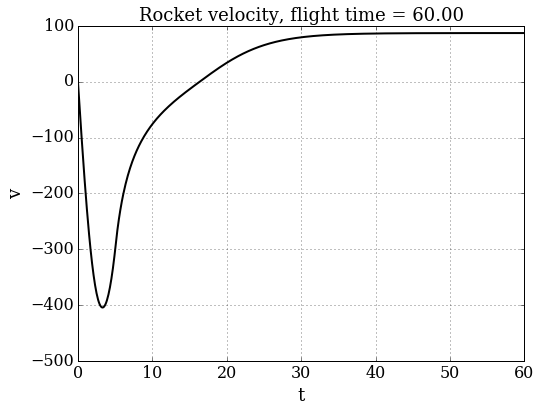

In [767]:
# visualization of the velocity
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r't', fontsize=18)
pyplot.ylabel(r'v', fontsize=18)
pyplot.title('Rocket velocity, flight time = %.2f' % T, fontsize=18)
pyplot.plot(t,v, 'k-', lw=2);

### Time to plot the mass of the rocket

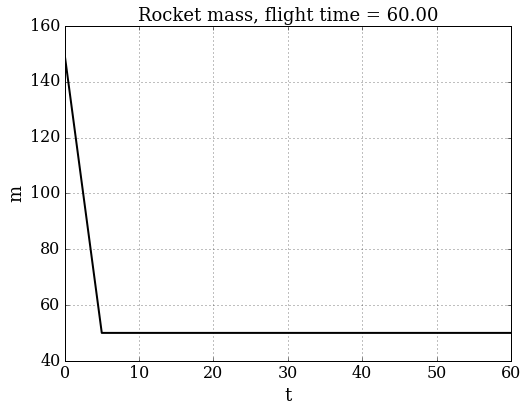

In [768]:
# visualization of the mass
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r't', fontsize=18)
pyplot.ylabel(r'm', fontsize=18)
pyplot.title('Rocket mass, flight time = %.2f' % T, fontsize=18)
pyplot.plot(t,m, 'k-', lw=2);

## Assessment:

To check your answers, you can register for [MAE 6286: Practical Numerical Methods with Python](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about).

1. At time $t=3.2s$, what is the mass (in kg) of rocket propellant remaining in the rocket?

2. What is the maximum speed of the rocket in $\frac{m}{s}$?
    At what time does this occur (in seconds)? 
    What is the altitude at this time (in meters)? 
    
3. What is the rocket's maximum altitude during flight (in meters)? At what time (in seconds) does this occur?

4. At what time (in seconds) does the rocket impact the ground? What is the velocity of the rocket (in $\frac{m}{s}$) at time of impact?

In [746]:
print('mass of remaing propellant= ', 100 - 20*dt*32)

mass of remaing propellant=  36.0


In [747]:
index = numpy.where(v < 0.00001)
#print(index)
print('vel = ', v[164])
print('height = ', h[164])
print('time = ', t[164])

vel =  95.1635456201
height =  3242.73105087
time =  16.4


In [748]:
print('max vel = ', max(v))
index = numpy.where(v == max(v))
print('time = ', t[index])
print('height = ', h[index])

max vel =  438.104940263
time =  [ 3.3]
height =  [ 923.44320184]


In [749]:
print('max h = ', max(h))
index = numpy.where(h == max(h))
print('time = ', t[index])

max h =  7085.76065137
time =  [ 60.]


In [750]:
index = numpy.where(h < 0.0000001)
#print('index = ', index)
print('time = ', t[509])
print('vel = ', v[509])

time =  50.9
vel =  87.3667558719


---

###### The cell below loads the style of the notebook.

In [1]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())